# Anomaly detection - KDE

In [325]:
import utils as ut
import matplotlib.pyplot as plt
n_run = 0



Read the data

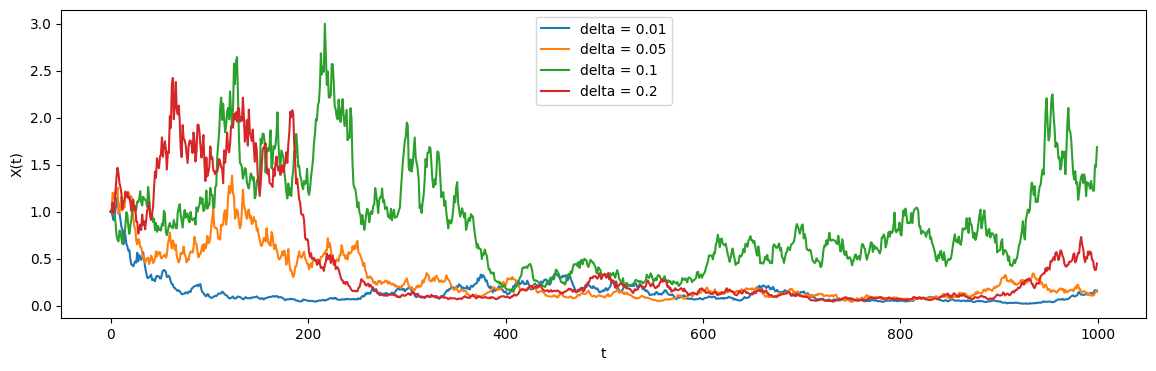

In [326]:
grid = ut.load_grid()
ut.plot_grid_datapoints(grid, ut.params, run=2, sigma=0.3, theta=0.01, mu=1, variation='delta')

Maximum of the data

In [ ]:
configuration = grid[n_run, 2, 1, 2, 3, :]

In [327]:
# grid[0, 2, 1, 2, 3, :] standard configuration
run = configuration.copy()
max_value = run.max()
max_value

5.5939360493584305

Normalize all the values

In [328]:
run = run / max_value

In [329]:
import plotly.graph_objects as go
import numpy as np

f1 = go.Figure(
    data = [
        go.Scatter(x=np.arange(1000), y=run, name="first"),
    ],
    layout = {"xaxis": {"title": "x axis"}, "yaxis": {"title": "y axis"}, "title": "My title"}
)
f1

In [330]:
q1 = np.quantile(run, 0.25) 
q3 = np.quantile(run, 0.75) 
sigma = run.std()
m =  len(run)
h = 0.9 * min(sigma, (q3-q1)/ 1.34) * m**(-0.2)
print(f'The estimated bandwidth is {h:.3f}')

The estimated bandwidth is 0.018


In [331]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(run.reshape(-1, 1))

KernelDensity(bandwidth=0.017833329593228416)

In [332]:
def plot_density_estimator_1D(estimator, xr, figsize=ut.figsize):
    # Build a new figure
    plt.close('all')
    plt.figure(figsize=figsize)
    # Plot the estimated density
    xvals = xr.reshape((-1, 1))
    dvals = np.exp(estimator.score_samples(xvals))
    plt.plot(xvals, dvals)
    plt.tight_layout()

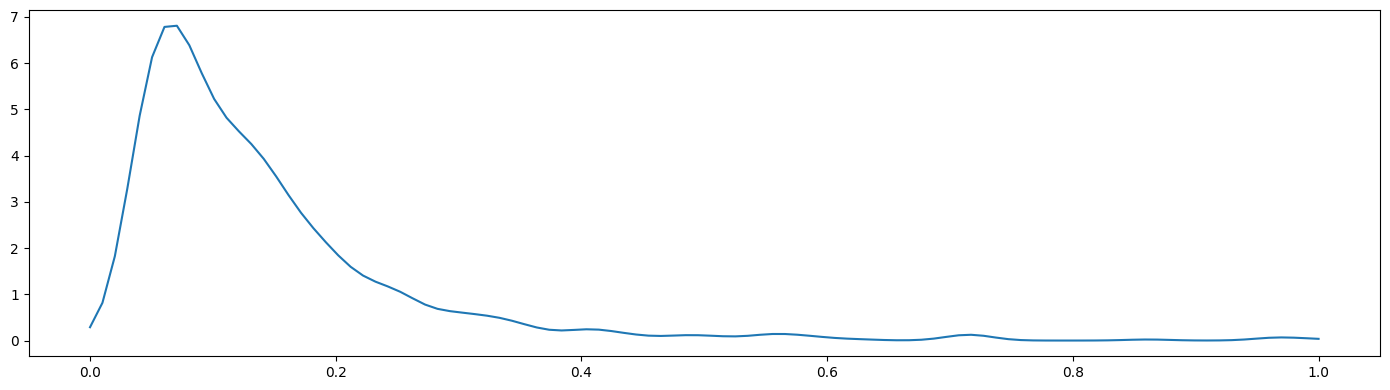

In [333]:
vmax = run.max()
xr = np.linspace(0, vmax, 100)
plot_density_estimator_1D(kde, xr)

In [334]:
anomaly_color = 'sandybrown'
prediction_color = 'yellowgreen'
training_color = 'yellowgreen'
validation_color = 'gold'
test_color = 'coral'

def plot_series(data, labels=None,
                    windows=None,
                    predictions=None,
                    highlights=None,
                    val_start=None,
                    test_start=None,
                    figsize=ut.figsize):
    # Open a new figure
    plt.close('all')
    plt.figure(figsize=figsize)
    # Plot data
    plt.plot(data.index, data.values, zorder=0)
    # Rotated x ticks
    plt.xticks(rotation=45)
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels],
                    color=anomaly_color, zorder=2)
    # Plot windows
    if windows is not None:
        for _, wdw in windows.iterrows():
            plt.axvspan(wdw['begin'], wdw['end'],
                        color=anomaly_color, alpha=0.3, zorder=1)
    
    # Plot training data
    if val_start is not None:
        plt.axvspan(data.index[0], val_start,
                    color=training_color, alpha=0.1, zorder=-1)
    if val_start is None and test_start is not None:
        plt.axvspan(data.index[0], test_start,
                    color=training_color, alpha=0.1, zorder=-1)
    if val_start is not None:
        plt.axvspan(val_start, test_start,
                    color=validation_color, alpha=0.1, zorder=-1)
    if test_start is not None:
        plt.axvspan(test_start, data.index[-1],
                    color=test_color, alpha=0.3, zorder=0)
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions],
                    color=prediction_color, alpha=.4, zorder=3)
    plt.tight_layout()


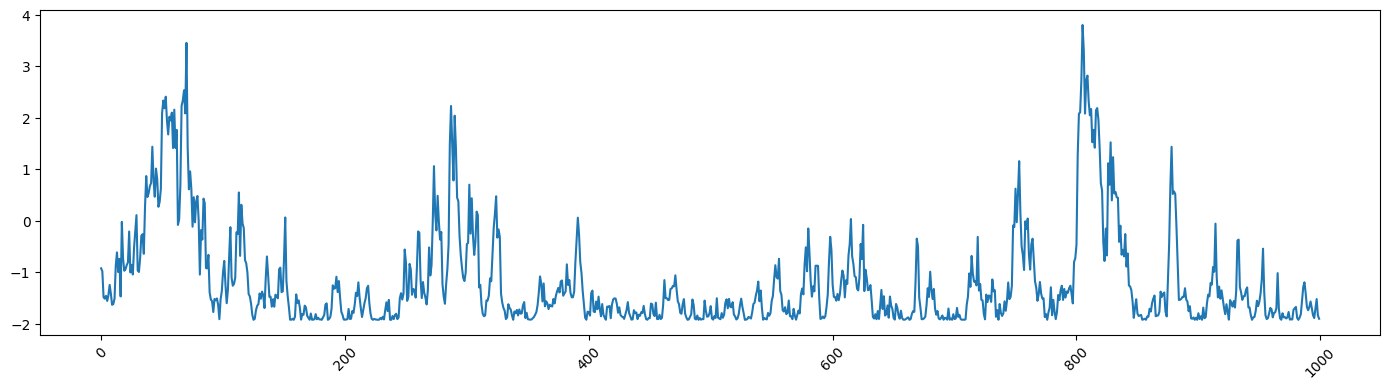

In [335]:
import pandas as pd
ldens = kde.score_samples(run.reshape(-1, 1)) # Obtain log probabilities
index = np.arange(len(run))
signal = pd.Series(index=index, data=-ldens) # Build series with neg. prob.
plot_series(signal) # Plot

In [336]:
scores = kde.score_samples(run.reshape(-1, 1))
thr = np.quantile(scores, 0.9)
pred = pd.Series(signal.index[signal >= thr])
print(thr)
print(pred)

1.9109213489982568
0      50
1      51
2      52
3      53
4      54
5      56
6      57
7      58
8      60
9      66
10     67
11     68
12     69
13     70
14    287
15    290
16    802
17    803
18    804
19    805
20    806
21    807
22    808
23    809
24    810
25    811
26    812
27    816
28    817
29    818
dtype: int64


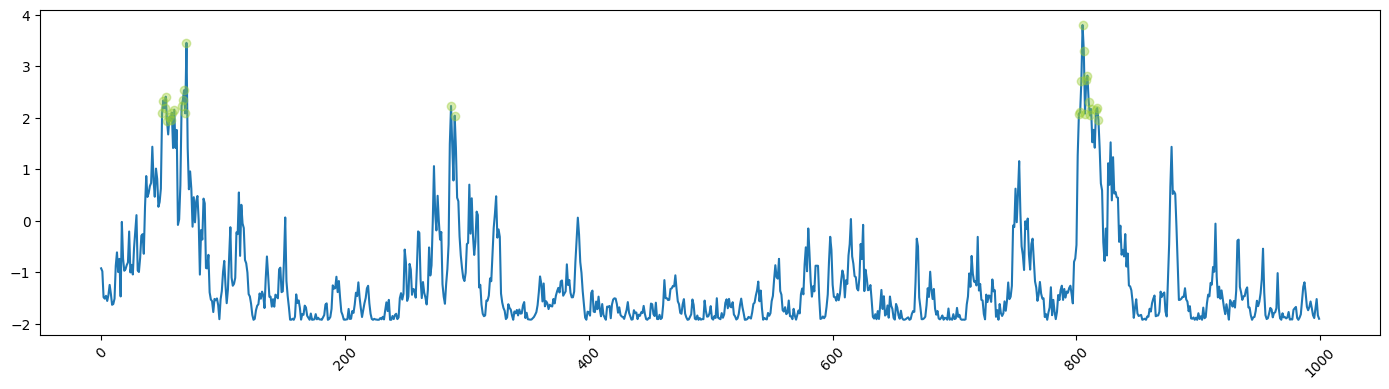

In [337]:
plot_series(signal, predictions=pred)

In [338]:
f1 = go.Figure(
    data = [
        go.Scatter(x=np.arange(1000), y=configuration, name="first"),
    ],
    layout = {"xaxis": {"title": "x axis"}, "yaxis": {"title": "y axis"}, "title": "My title"}
)
f1

In [422]:
l = []

for i in range(30):
    run = grid[i, 2, 3, 2, 3, :].copy()
    max_value = run.max()
    run = run / max_value
    q1 = np.quantile(run, 0.25) 
    q3 = np.quantile(run, 0.75) 
    sigma = run.std()
    m =  len(run)
    h = 0.9 * min(sigma, (q3-q1)/ 1.34) * m**(-0.2)
    kde = KernelDensity(kernel='gaussian', bandwidth=h)
    kde.fit(run.reshape(-1, 1))
    scores = kde.score_samples(run.reshape(-1, 1))
    l.append(np.quantile(scores, 0.99))
    pred = pd.Series(signal.index[signal >= thr])

In [423]:
thr = np.mean(l)
thr

1.493797342280978

In [424]:
preds = []
for i in range(30):
    run = grid[i, 2, 3, 2, 3, :].copy()
    max_value = run.max()
    run = run / max_value
    q1 = np.quantile(run, 0.25) 
    q3 = np.quantile(run, 0.75) 
    sigma = run.std()
    m =  len(run)
    h = 0.9 * min(sigma, (q3-q1)/ 1.34) * m**(-0.2)
    kde = KernelDensity(kernel='gaussian', bandwidth=h)
    kde.fit(run.reshape(-1, 1))
    ldens = kde.score_samples(run.reshape(-1, 1)) # Obtain log probabilities
    index = np.arange(len(run))
    signal = pd.Series(index=index, data=-ldens) # Build series with neg. prob.
    scores = kde.score_samples(run.reshape(-1, 1))
    pred = pd.Series(signal.index[signal >= thr])
    preds.append(pred)

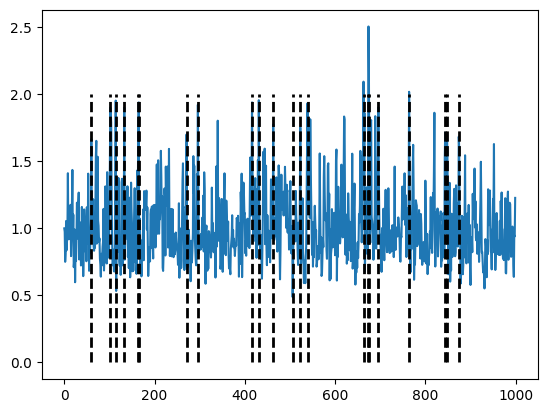

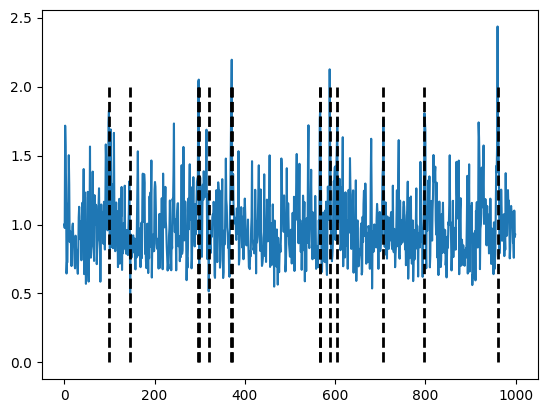

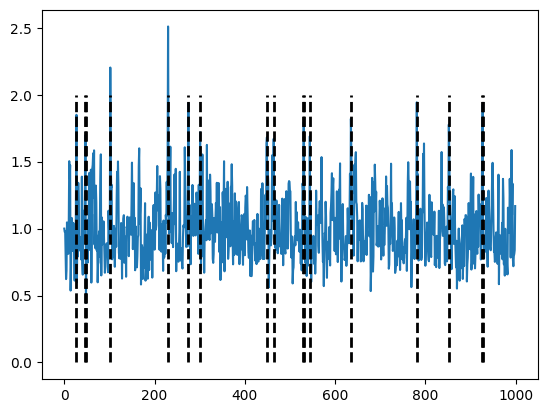

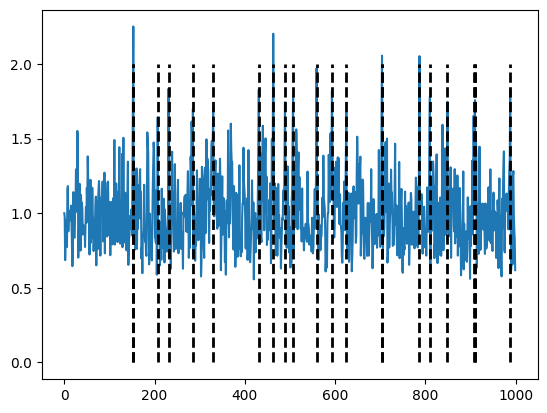

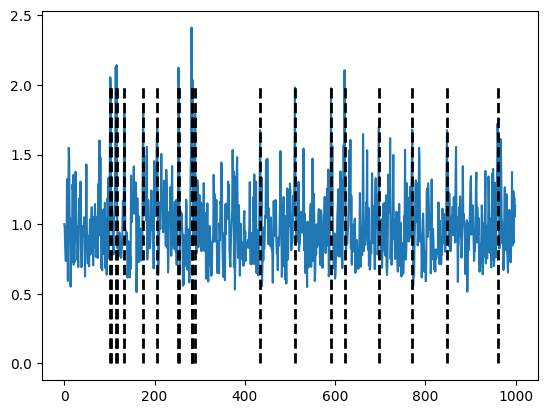

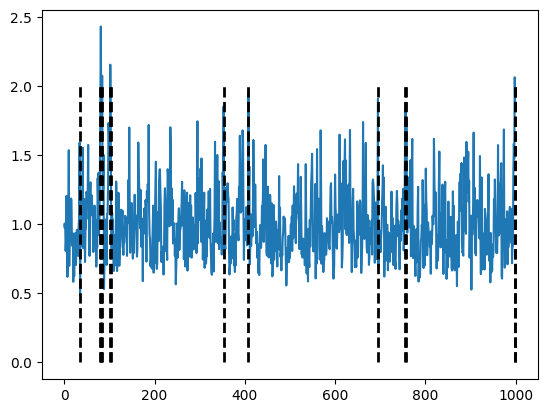

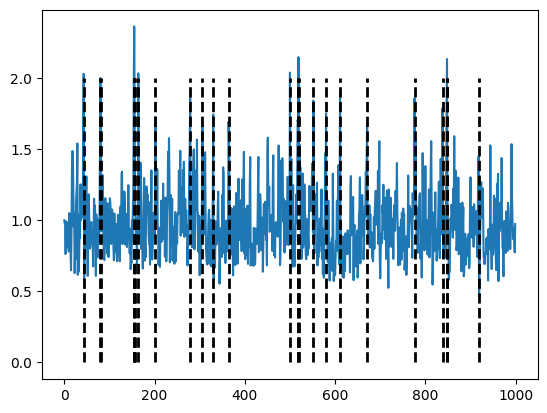

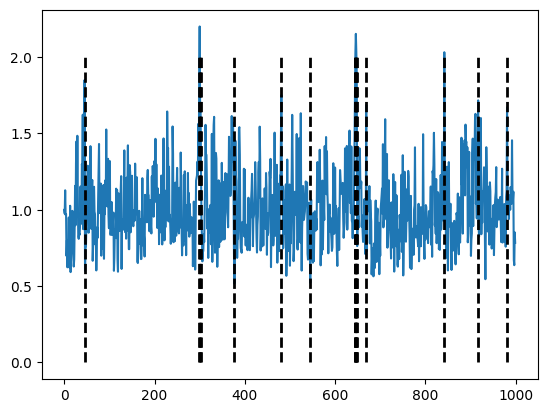

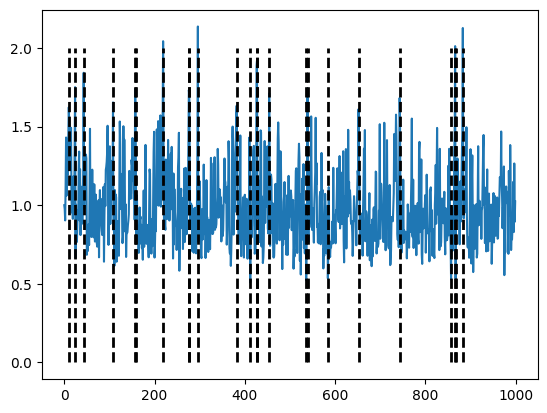

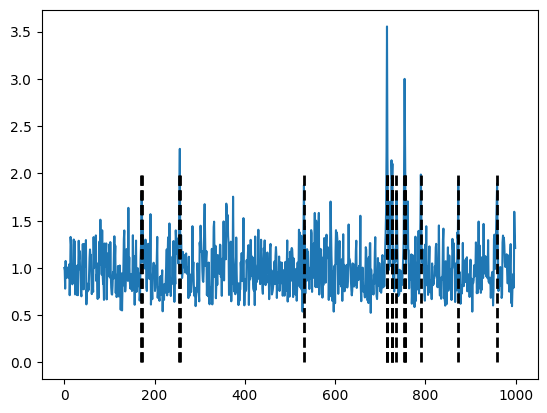

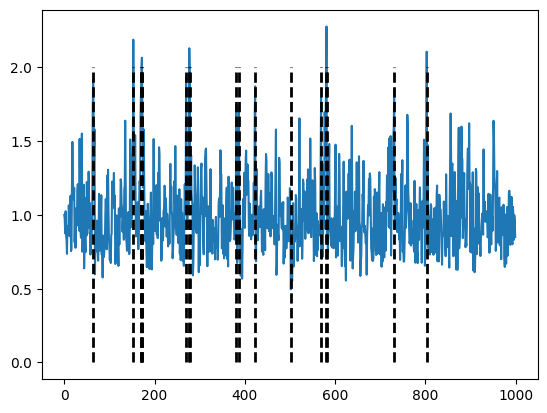

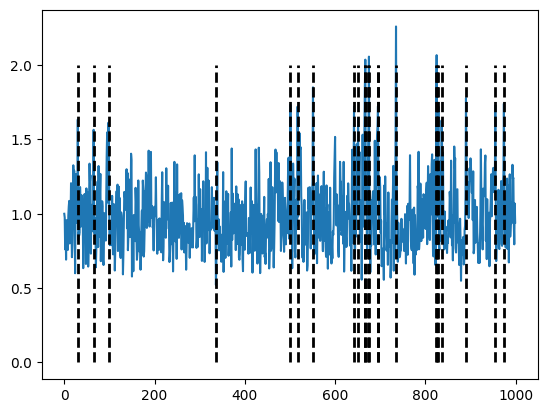

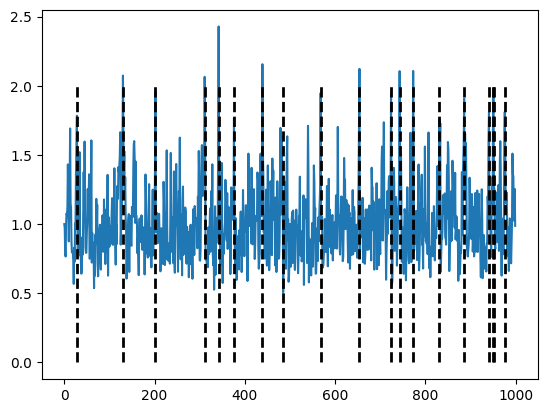

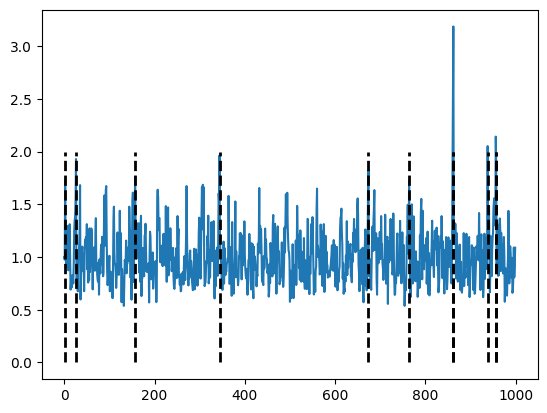

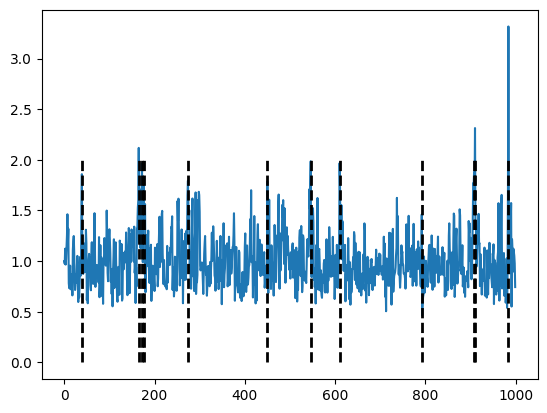

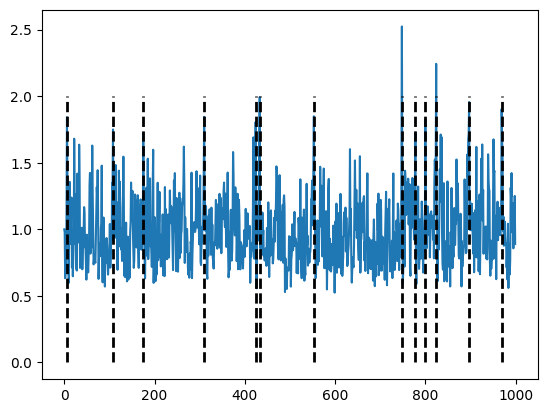

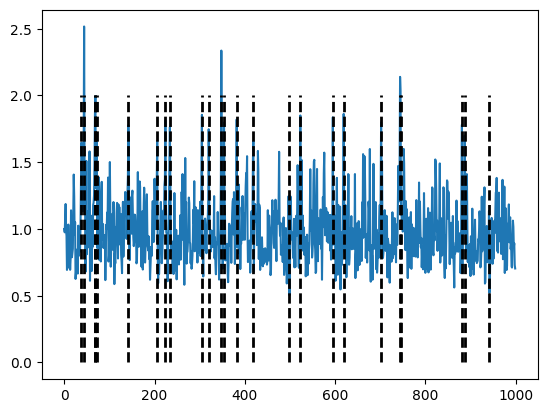

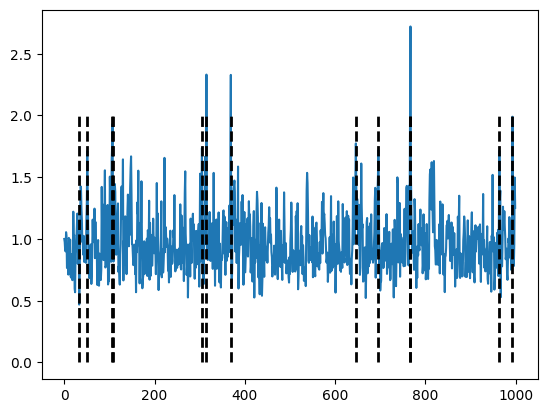

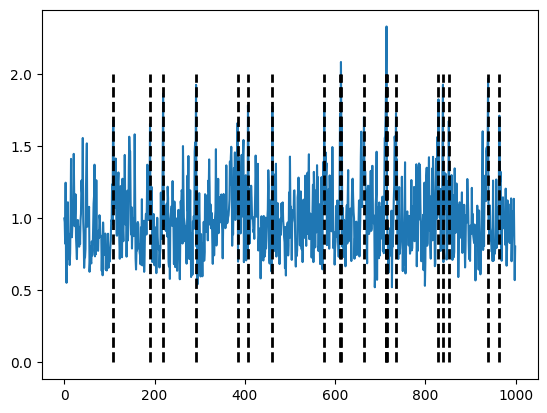

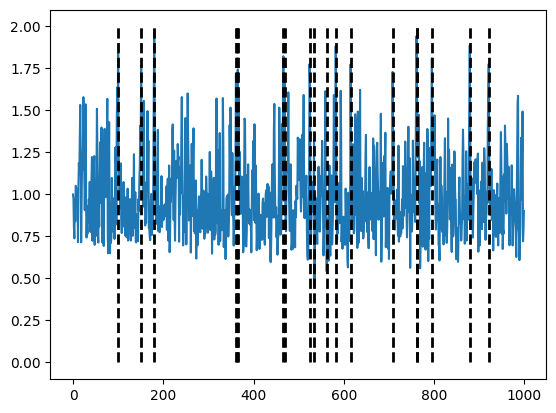

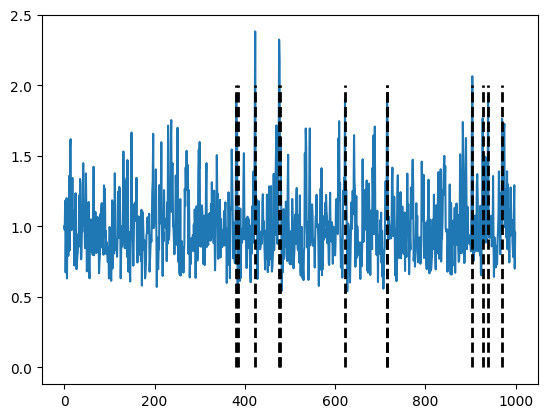

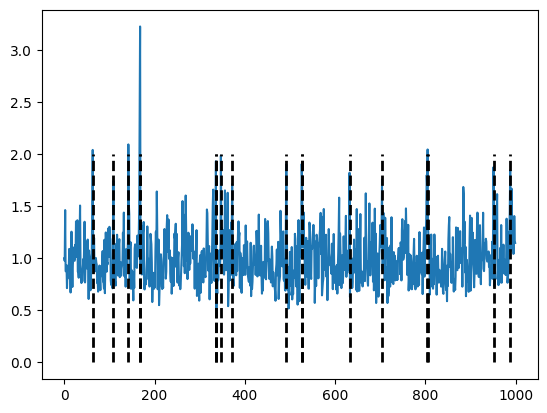

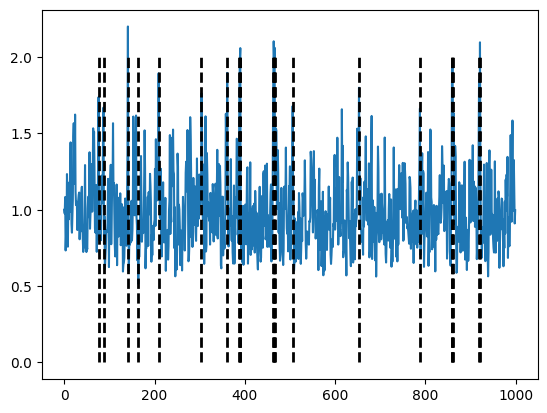

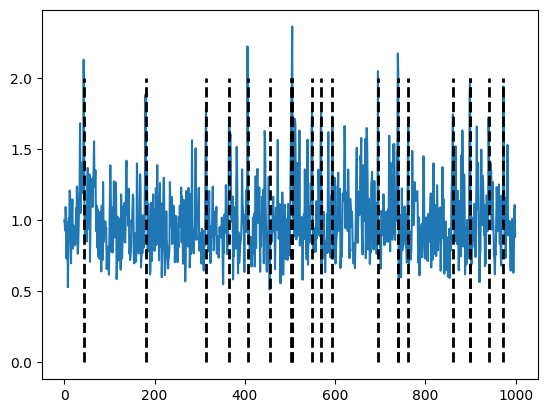

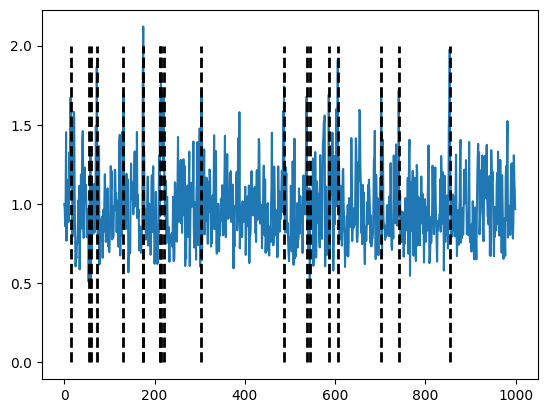

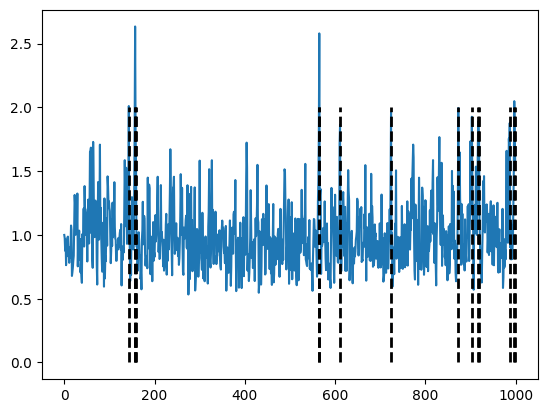

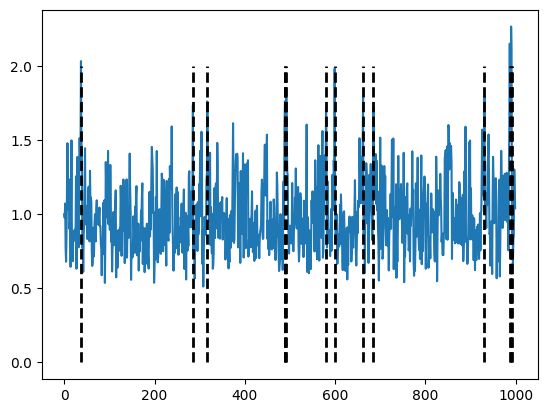

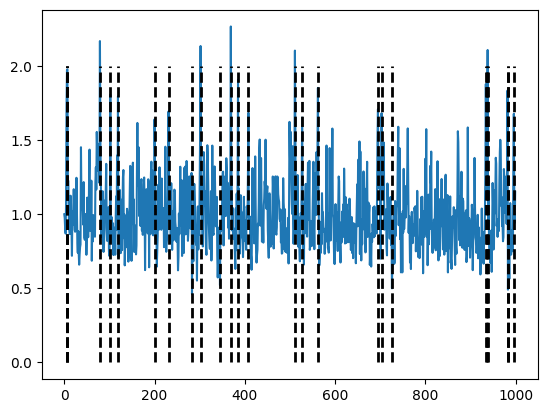

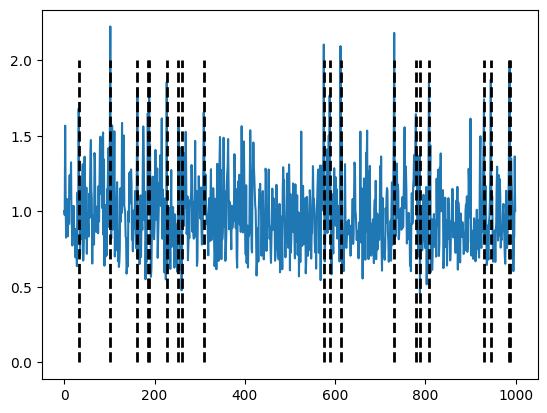

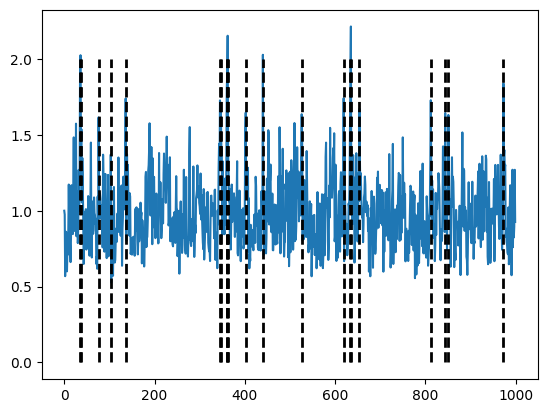

In [425]:
xs = [1, 10]
for i in range(30):
    run = grid[i, 2, 3, 2, 3, :].copy()
    plt.plot(run)
    plt.vlines(x=preds[i], ymin=0, ymax=2, colors='black', ls='--', lw=2)
    plt.show()